In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Background

* Layer-wise greedy pretraining: Find the better initialized variables for `each layer`, use minibatch to find the best hyperparameters. 
* End-to-end (nowadays)

# Local Minima vs. Global Minima

* Reason:
    * Model identifiability
    * Equivalence (e.g. relu)

## Error Surface

* Loss value vs Time peroid 
    * Is the error surface uneven ?
    * Can not point to the right direction ?

## Local Minima (2014, Goodfellow)

The local minina issue is not the main issue to the error surface, but pointing to right direction.

In [2]:
# uncomment the below line to download the data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/Users/jiankaiwang/Desktop/devops/tmp/MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /Users/jiankaiwang/Desktop/devops/tmp/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /Users/jiankaiwang/Desktop/devops/tmp/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /Users/jiankaiwang/Desktop/devops/tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /Users/jiankaiwang/Desktop/devops/tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
def layer(input, weight_shape, bias_shape):
    weight_std = (2.0 / weight_shape[0]) ** 0.5
    w_init = tf.random_normal_initializer(stddev=weight_std)
    b_init = tf.constant_initializer(value=0)
    W = tf.get_variable(name="W", shape=weight_shape, initializer=w_init)
    b = tf.get_variable(name="b", shape=bias_shape, initializer=b_init)
    return tf.nn.relu(tf.matmul(input, W) + b)

In [4]:
def inference(x):
    with tf.variable_scope("hidden_1"):
        hidden_1 = layer(x, [784, 256], [256])
        
    with tf.variable_scope("hidden_2"):
        hidden_2 = layer(hidden_1, [256, 256], [256])
    
    with tf.variable_scope("output"):
        output = layer(hidden_2, [256, 10], [10])
        
    return output

In [5]:
def loss(output, y):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=y)
    loss = tf.reduce_mean(cross_entropy)
    return loss

INFO:tensorflow:Restoring parameters from /Users/jiankaiwang/Desktop/devops/tmp/basic_tf/model-checkpoint-550
Instructions for updating:
Use `tf.variables_initializer` instead.


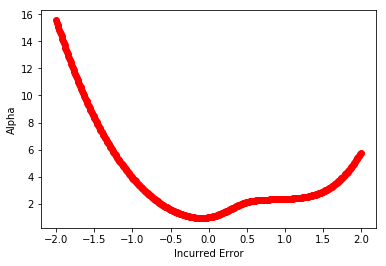

In [6]:
x = tf.placeholder("float", [None, 784])
y = tf.placeholder("float", [None, 10])

with tf.Session() as sess:
    with tf.variable_scope("mlp_model") as scope:
        output_opt = inference(x)
        cost_opt = loss(output_opt, y)
        saver = tf.train.Saver()
        scope.reuse_variables()
        
        var_list_opt = ["hidden_1/W", "hidden_1/b", "hidden_2/W", "hidden_2/b", "output/W", "output/b"]
        var_list_opt = [tf.get_variable(v) for v in var_list_opt]
        saver.restore(sess, "/Users/jiankaiwang/Desktop/devops/tmp/basic_tf/model-checkpoint-550")
        #print(sess.run(var_list_opt[0]))
        
    with tf.variable_scope("mlp_init") as scope:
        output_rand = inference(x)
        cost_rand = loss(output_rand, y)
        scope.reuse_variables()
        
        var_list_rand = ["hidden_1/W", "hidden_1/b", "hidden_2/W", "hidden_2/b", "output/W", "output/b"]
        var_list_rand = [tf.get_variable(v) for v in var_list_rand]
        init_op = tf.initialize_variables(var_list_rand)
        sess.run(init_op)
        
    with tf.variable_scope("mlp_inter") as scope:
        alpha = tf.placeholder("float", [1,1])
        beta = 1 - alpha
        
        h1_W_inter = var_list_opt[0] * beta + var_list_rand[0] * alpha
        h1_b_inter = var_list_opt[1] * beta + var_list_rand[1] * alpha
        h2_W_inter = var_list_opt[2] * beta + var_list_rand[2] * alpha
        h2_b_inter = var_list_opt[3] * beta + var_list_rand[3] * alpha
        o_W_inter = var_list_opt[4] * beta + var_list_rand[4] * alpha
        o_b_inter = var_list_opt[5] * beta + var_list_rand[5] * alpha
        
        h1_inter = tf.nn.relu(tf.matmul(x, h1_W_inter) + h1_b_inter)
        h2_inter = tf.nn.relu(tf.matmul(h1_inter, h2_W_inter) + h2_b_inter)
        o_inter = tf.nn.relu(tf.matmul(h2_inter, o_W_inter) + o_b_inter)
        
        cost_inter = loss(o_inter, y)
        
    results = []
    
    for a in np.arange(-2, 2, 0.01):
        feed_dict = {x: mnist.test.images, y: mnist.test.labels, alpha: [[a]]}
        cost = sess.run([cost_inter], feed_dict=feed_dict)
        results.append(cost)
        
plt.plot(np.arange(-2,2,0.01), results, 'ro')
plt.xlabel("Incurred Error")
plt.ylabel("Alpha")
plt.show()

# Flattern Error Surface vs. Saddle Points

* It is rare to find a local minima or local maxima when data dimension increases.

# Gradient Pointing to Wrong Direction

* The gradient shows the local message, but not to show the global scaled message.
* Hessian matrix
* ill-conditioned matrix

# Momentum-based Optimization

In [7]:
step_range = 10
step_choices = range(-1 * step_range, step_range + 1)
rand_walk = [random.choice(step_choices) for i in range(100)]
print(rand_walk)

[-2, -2, -3, -8, -7, 6, -4, -3, -7, 8, 8, -10, 6, 7, -6, -4, -5, -7, 10, 8, -2, 1, 8, -9, -8, 2, -7, -10, -4, 0, 5, 7, -2, -4, -7, 6, -10, -9, 3, -7, 1, -2, 2, -4, 7, -6, 6, 9, -6, 7, -7, -4, 4, -8, 10, 2, 5, -2, 2, -7, 1, -6, 6, -2, 6, -10, 5, -2, -8, 1, -2, -4, -8, -6, -2, 7, -9, 10, 0, -10, 8, 10, 0, 3, -2, -3, -8, 6, 7, -5, 7, 2, -6, 9, 6, -1, 8, 3, 8, -4]


In [8]:
momentum_rand_walk = [random.choice(step_choices)]
momentum = 9e-1

for i in range(len(rand_walk)):
    prev = momentum_rand_walk[-1]   # similar with v
    rand_choice = random.choice(step_choices)   # similar with grad
    new_step = momentum * prev + (1 - momentum) * rand_choice   # (1 - momentum) similar with learning_rate
    momentum_rand_walk.append(new_step)
    
print(momentum_rand_walk)

[-2, -2.1, -2.29, -2.6609999999999996, -1.3949, -1.45541, -1.409869, -1.5688821000000002, -0.5119938900000004, 0.33920549899999947, 0.30528494909999954, 0.8747564541899995, 1.7872808087709995, 1.3085527278938995, 1.9776974551045094, 1.1799277095940586, 0.06193493863465305, -0.24425855522881218, -1.0198326997059308, -0.3178494297353379, -0.2860644867618041, 0.24254196191437616, -0.5817122342770613, -1.123541010849355, -1.3111869097644195, -1.3800682187879776, -1.4420613969091798, -0.7978552572182619, -0.11806973149643585, -0.20626275834679225, 0.21436351748788687, -0.20707283426090173, 0.11363444916518836, -0.1977289957513304, 0.22204390382380254, 0.3998395134414222, 0.5598555620972799, 1.5038700058875518, 1.053483005298797, 1.5481347047689171, 0.7933212342920255, 1.4139891108628229, 2.07259019977654, 0.8653311797988863, 1.4787980618189975, 0.5309182556370979, 0.3778264300733882, -0.05995621293395054, -0.4539605916405554, -0.9085645324764997, -0.3177080792288499, -0.18593727130596494, -

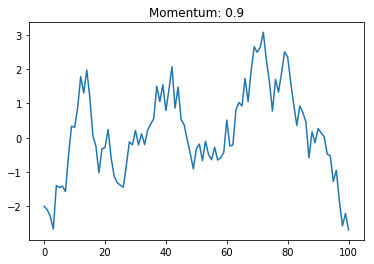

In [9]:
plt.plot(momentum_rand_walk)
plt.title("Momentum: {}".format(momentum))
plt.show()

## Momentum in Tensorflow

The example code

```python
m_learning_rate = 1e-2
m_momentum = 9e-1
m_opt = tf.train.MomentumOptimizer(momentum=m_momentum, learning_rate=m_learning_rate)
m_op = m_opt.minimize(cost, global_step = global_step)
```

# Second derived function

* Conjugate Gradient Descent
* BFGS -> L-BFGS

# Learning Rate Adaption

## AdaGrad

* It cumulates history gradients.
* Larger gradients, larger learning rate
* It pretends to lower the learning rate in generally and this property causes bad results in some models.

```python
tf.train.AdagradDAOptimizer(learning_rate=learning_rate, \
                            initial_gradient_squared_accumulator_value=0.1, \
                            use_locking=False, \
                            name="adagrad")
```

## RMSProp

* Use `decay` to conserve the history gradients.
* Lower decay, lower the inference from the history.
* Solve Adagrad problems that learning rate decays even not in flattern surface.

```python
# epsilon is the same setting with initial_gradient_squared_accumulator_value in Adagrad
tf.train.RMSPropOptimizer(learning_rate=learning_rate, \
                          decay=0.9, \
                          momentum=0.0, \
                          epsilon=1e-10, \
                          use_locking=False, \
                          name="RMSProp")
```

## Adam

* Combine `Momentum` and `RMSProp`.

```python
# beta1 : the hyperparameter for momentum
# beta2 : the hyperparameter for velocity
tf.train.AdamOptimizer(learning_rate=learning_rate, \
                      beta1=9e-1, \
                      beta2=0.999, \
                      epsilon=1e-8, \
                      use_locking=False, \
                      name="Adam")
```